# Quantum Variational Classifier in PennyLane on Simplified Jet Dataset

Few things to keep in mind when working in PennyLane:
* Different from previous examples, the quantum node takes the data as a keyword argument x (with the default value None). Keyword arguments of a quantum node are considered as fixed when calculating a gradient; they are never trained.


Work based on tutorial from https://pennylane.readthedocs.io/en/latest/tutorials/notebooks.html.  
Minor changes (such as changing dataset), have been applied. However the original result can be reproduced based if load_data is called with 'example' argument.

Import all necessary libraries.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample
from scipy import interp

import os

In [2]:
dev = qml.device('default.qubit', wires=2)

Data encodings, from classical to quantum representation:

In [3]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1]) ** 2 / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12) )
    beta1 = 2 * np.arcsin(np.sqrt(x[3]) ** 2 / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12) )
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):

    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Loss Function Definition, and other classical ML methods:

In [4]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)

    return loss

def cost(weights, features, labels):

    predictions = [variational_classifier(weights, angles=f) for f in features]

    return square_loss(labels, predictions)

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

Define a quantum model:

In [5]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)

    qml.CNOT(wires=[0, 1])

def variational_classifier(var, angles=None):

    weights = var[0]
    bias = var[1]

    return circuit(weights, angles=angles) + bias

@qml.qnode(dev)
def circuit(weights, angles=None):

    statepreparation(angles)
    
    for W in weights:
        layer(W)

    return qml.expval.PauliZ(0)

Data Loading:  
There is a problem on this stage. When going from classical data to quantum representation there is a significant loss of discriminative power in the data. Later visualizations will show it.

Higgs NaNs: False
QCD NaNs: False
Higgs NaNs: False
QCD NaNs: False
X_pad maxs: [1. 1.]
X_pad mins: [0. 0.]
X Norm NaNs: False
First X sample (original)  : [200.           2.63858235]
First X sample (padded)    : [1.        0.0623862 0.        0.3      ]
First X sample (normalized): [0.95612081 0.05964875 0.         0.28683624]
First features sample      : [ 0.58184533 -1.57079284  1.57079284 -0.06230546  0.06230546]
Shape of features          : (2000, 5)
Number of Higgs            : 1000
Number of QCD              : 1000


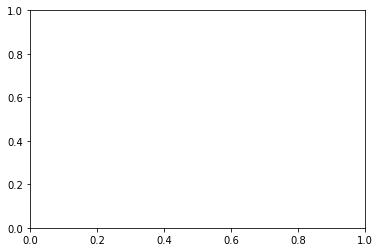

In [9]:
name = 'mass d2'
# Columns read from dataset - Max of 4 - (Order matters I believe)
# 'pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2'
columns = ['mass', 'd2']

def load_data(dataset='jet', plot_save_all=False):
    """
    :param dataset: Either 'jet' or 'example' 
    :param plot_save_all: Plots and saves images of all columns in input, non-formatted dataset.
        Currently only jet dataset.
    """
    if dataset.lower() == 'jet':
        qcd = pd.read_pickle('data/qcd_1000.pkl')
        h = pd.read_pickle('data/higgs_1000.pkl')
        
        # Make mass within the range (no cuts, though)
        qcd.loc[qcd.loc[:, 'mass'] > 200, 'mass'] = 200
        qcd.loc[qcd.loc[:, 'mass'] < 50, 'mass'] = 50
        
        h.loc[h.loc[:, 'mass'] > 200, 'mass'] = 200
        h.loc[h.loc[:, 'mass'] < 50, 'mass'] = 50
        
        # Do cut on pT - not on this data
#         qcd = qcd[(250 < qcd['pt']) & (qcd['pt'] < 500)]
#         h = h[(250 < h['pt']) & (h['pt'] < 500)]

        # Plot initial dataset
        if plot_save_all:
            if not os.path.exists('plots/init_data'):
                os.makedirs('plots/init_data')
            # Plot points in 2D
            for col1 in h.keys():
                for col2 in h.keys():
                    if col1 == col2:
                        continue
                    plt.scatter(h.loc[:, col1], h.loc[:, col2], c='orange', alpha=0.5, edgecolors='k', label='Higgs')
                    plt.scatter(qcd.loc[:, col1], qcd.loc[:, col2], c='mediumseagreen', alpha=0.5, edgecolors='k', label='QCD')
                    plt.xlabel(col1)
                    plt.ylabel(col2)
                    plt.legend()
                    plt.title('Original, unmodified data for dims {} and {}'.format(col1, col2))
                    plt.savefig('plots/init_data/plot {} {}'.format(col1, col2))
                    plt.clf()
                    plt.cla()

            # Plot histograms
            n_bins=100
            for col in h.keys():
                # Normal values.
                plt.hist(h.loc[:, col], bins=n_bins, color='orange', stacked=True, label='Higgs')
                plt.hist(qcd.loc[:, col], bins=n_bins, color='mediumseagreen', stacked=True, label='QCD')
                plt.title('Distribution of {} in original dataset'.format(col))
                plt.legend()
                plt.savefig('plots/init_data/hist {}'.format(col))
                plt.clf()
                plt.cla()

                # Normalized
                plt.hist(h.loc[:, col], bins=n_bins, density=True, color='orange', histtype='step', label='Higgs')
                plt.hist(qcd.loc[:, col], bins=n_bins, density=True, color='mediumseagreen', histtype='step', label='QCD')
                plt.title('Distribution of {} in original dataset'.format(col))
                plt.legend()
                plt.savefig('plots/init_data/hist_norm {}'.format(col))
                plt.clf()
                plt.cla()
        
        # Randomly downsample
        # First, reorder cols, cause otherwise there will be nans
        if len(h) > len(qcd):
            h_idx = np.random.choice(h.index, min(len(qcd), len(h)), replace=False)
            h = h.loc[h_idx, :]
        elif len(qcd) > len(h):
            qcd_idx = np.random.choice(qcd.index, min(len(qcd), len(h)), replace=False)
            qcd = qcd.loc[qcd_idx, :]
        
        print('Higgs NaNs: {}'.format(np.any(np.isnan(h))))
        print('QCD NaNs: {}'.format(np.any(np.isnan(qcd))))
        
        qcd = qcd.loc[:, columns]
        h = h.loc[:, columns]

        # See if there are any NaNs in loaded data
        print('Higgs NaNs: {}'.format(np.any(np.isnan(h))))
        print('QCD NaNs: {}'.format(np.any(np.isnan(qcd))))

        # Do a linear shift to make sure every col is >= 0
        # qcd = np.add(qcd, np.abs(np.min(qcd, axis=0)))
        # h = np.add(h, np.abs(np.min(h, axis=0)))
        
        y = np.zeros(len(qcd))
        y = np.concatenate((y, np.ones(len(h))))
        y = np.multiply(2., y) - 1

        # Combine datasets
        X = np.concatenate((qcd, h))

        X_pad = X
        # Normalize each input to [0, 1]
        X_pad = np.subtract(X_pad, np.min(X_pad, axis=0)) # [0, infty]
        X_pad = np.divide(X_pad, np.max(X_pad, axis=0)) # Values should be between [0, 1] now
        
        print("X_pad maxs: {}".format(np.max(X_pad, axis=0)))
        print("X_pad mins: {}".format(np.min(X_pad, axis=0)))
        
        # Pad with constant cols 0, 0.3, 0.6, 0.9 if necessary
        cols_to_pad = 4 - X.shape[1]
        for i in range(cols_to_pad):
            X_pad = np.c_[X_pad, i * 0.3 * np.ones((len(X_pad), 1))]
        
        normalization = np.sqrt(np.sum(X_pad ** 2, -1))
        X_norm = (X_pad.T / normalization).T


        # NaN check
        print('X Norm NaNs: {}'.format(np.any(np.isnan(X_norm))))

        # angles for state preparation are new features
        features = np.array([get_angles(x) for x in X_norm])

        # Remove NaN rows from every dataset (so that the images in next cell make sense)
        indices = ~np.any(np.isnan(features), axis=1)
        features = features[indices]
        Y = y[indices]
        X_norm = X_norm[indices]
        X = X[indices]

        print("First X sample (original)  :", X[0])
        print("First X sample (padded)    :", X_pad[0])
        print("First X sample (normalized):", X_norm[0])
        print("First features sample      :", features[0])
        print("Shape of features          :", features.shape)
        print("Number of Higgs            :", len(np.where(Y == 1)[0]))
        print("Number of QCD              :", len(np.where(Y == -1)[0]))
        return features, Y, X
    
    elif dataset.lower() == 'example':
        data = np.loadtxt("data/iris_classes1and2_scaled.txt")
        X = data[:, 0:2]
        print("First X sample (original)  :", X[0])

        # pad the vectors to size 2^2 with constant values
        padding = 0.3 * np.ones((len(X), 1))
        X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1)) ] 
        print("First X sample (padded)    :", X_pad[0])

        # normalize each input
        normalization = np.sqrt(np.sum(X_pad ** 2, -1))
        X_norm = (X_pad.T / normalization).T
        print("First X sample (normalized):", X_norm[0])

        # angles for state preparation are new features
        features = np.array([get_angles(x) for x in X_norm])  
        print("First features sample      :", features[0])

        Y = data[:, -1]
        plt.figure()
        dim1 = 0
        dim2 = 1
        plt.scatter(X[:,dim1][Y== 1], X[:,dim2][Y== 1], c='r', marker='o', edgecolors='k')
        plt.scatter(X[:,dim1][Y==-1], X[:,dim2][Y==-1], c='b', marker='o', edgecolors='k')
        plt.title("X vectors (dims {} and {})".format(dim1, dim2))
        plt.show()
        return features, Y, X
    else:
        raise ValueError('No dataset with name: {} exists.'.format(dataset))


features, Y, X = load_data('jet', plot_save_all=True)
# _, _, _ = load_data('jet', plot_save_all=True)

while len(columns) < 4:
    columns += ['stub']

Plot the parameter space of input data (aka features):

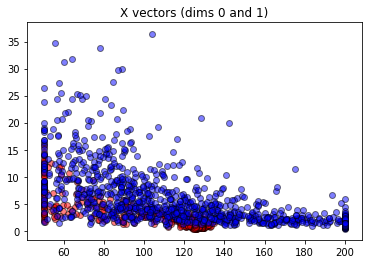

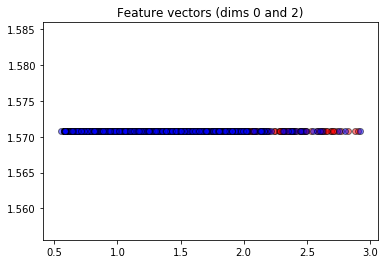

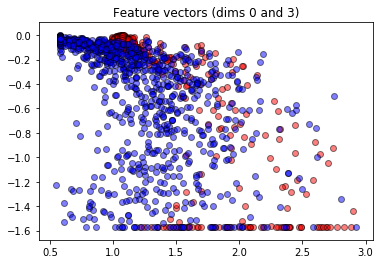

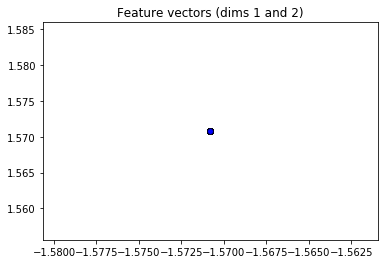

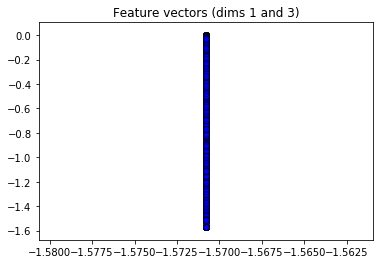

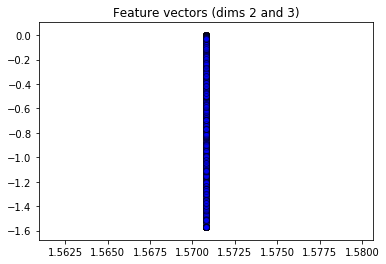

In [10]:
%matplotlib inline
plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X[:,dim1][Y== 1], X[:,dim2][Y== 1], c='r', marker='o', alpha=0.5, edgecolors='k')
plt.scatter(X[:,dim1][Y==-1], X[:,dim2][Y==-1], c='b', marker='o', alpha=0.5, edgecolors='k')
plt.title("X vectors (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 2
plt.scatter(features[:,dim1][Y== 1], features[:,dim2][Y== 1], c='r', marker='o', alpha=0.5, edgecolors='k')
plt.scatter(features[:,dim1][Y==-1], features[:,dim2][Y==-1], c='b', marker='o', alpha=0.5, edgecolors='k')
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:,dim1][Y== 1], features[:,dim2][Y== 1], c='r', marker='o', alpha=0.5, edgecolors='k')
plt.scatter(features[:,dim1][Y==-1], features[:,dim2][Y==-1], c='b', marker='o', alpha=0.5, edgecolors='k')
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 1
dim2 = 2
plt.scatter(features[:,dim1][Y== 1], features[:,dim2][Y== 1], c='r', marker='o', alpha=0.5, edgecolors='k')
plt.scatter(features[:,dim1][Y==-1], features[:,dim2][Y==-1], c='b', marker='o', alpha=0.5, edgecolors='k')
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 1
dim2 = 3
plt.scatter(features[:,dim1][Y== 1], features[:,dim2][Y== 1], c='r', marker='o', alpha=0.5, edgecolors='k')
plt.scatter(features[:,dim1][Y==-1], features[:,dim2][Y==-1], c='b', marker='o', alpha=0.5, edgecolors='k')
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 2
dim2 = 3
plt.scatter(features[:,dim1][Y== 1], features[:,dim2][Y== 1], c='r', marker='o', alpha=0.5, edgecolors='k')
plt.scatter(features[:,dim1][Y==-1], features[:,dim2][Y==-1], c='b', marker='o', alpha=0.5, edgecolors='k')
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

Train Test Split:

In [11]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[: num_train]]
X_val   = X[index[num_train :]]

Hyperparameters of Quantum Algo:

In [12]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

opt = NesterovMomentumOptimizer(0.01)  # ? AdamOptimizer(0.01, beta1=0.9, beta2=0.999)
batch_size = 5

Training:

In [13]:
## Train the variational classifier
var = var_init

# Track stuff like keras
hist = {}
hist['val_loss'] = []
hist['val_acc'] = []
hist['tr_loss'] = []
hist['tr_acc'] = []
epochs = 60

# Save best model based on cost of validation
best_var = var_init
best_acc = 0

save_best = True

for it in range(epochs):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size, ))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val]

    # Compute accuracy on train and validation set
    tr_acc = accuracy(Y_train, predictions_train)
    val_acc = accuracy(Y_val, predictions_val)

    tr_loss = cost(var, features, Y_train)
    val_loss = cost(var, features, Y_val)
    
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)
    hist['tr_loss'].append(tr_loss)
    hist['tr_acc'].append(tr_acc)
    
    if tr_acc > best_acc:
        best_var = var
        best_acc = tr_acc
    
    print("Iter: {:5d} | Cost train: {:0.7f} | Acc train: {:0.7f} | Cost val: {:0.7f} | Acc val: {:0.7f} "
          "".format(it+1, tr_loss, tr_acc, val_loss, val_acc))

if save_best:
    np.save("{}_best_weights".format(name), best_var)

Iter:     1 | Cost train: 1.2798485 | Acc train: 0.5193333 | Cost val: 1.3805591 | Acc val: 0.5320000 
Iter:     2 | Cost train: 1.2632820 | Acc train: 0.5246667 | Cost val: 1.3625676 | Acc val: 0.5340000 
Iter:     3 | Cost train: 1.2463419 | Acc train: 0.5273333 | Cost val: 1.3451245 | Acc val: 0.5340000 
Iter:     4 | Cost train: 1.2109073 | Acc train: 0.5386667 | Cost val: 1.3061637 | Acc val: 0.5540000 
Iter:     5 | Cost train: 1.1813320 | Acc train: 0.5540000 | Cost val: 1.2719698 | Acc val: 0.5820000 
Iter:     6 | Cost train: 1.1687405 | Acc train: 0.5646667 | Cost val: 1.2565187 | Acc val: 0.5900000 
Iter:     7 | Cost train: 1.1683872 | Acc train: 0.5666667 | Cost val: 1.2557318 | Acc val: 0.5920000 
Iter:     8 | Cost train: 1.1707253 | Acc train: 0.5700000 | Cost val: 1.2579183 | Acc val: 0.5940000 
Iter:     9 | Cost train: 1.1600725 | Acc train: 0.5813333 | Cost val: 1.2425702 | Acc val: 0.6160000 
Iter:    10 | Cost train: 1.1549487 | Acc train: 0.6040000 | Cost val: 1.

### Visualization of Model Training

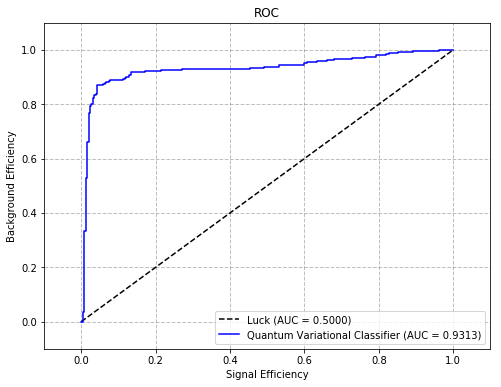

In [14]:
# ROC Curves
line_styles = ['-', '--', '-.', ':']  # All line styles in matplotlib
colors = ['b', 'g', 'r', 'k', 'c', 'm']  # Some example colors

def draw_roc(y_predict, y_true, label='', title='', index=0):

    if isinstance(y_predict, list):
        y_predict = np.array(y_predict)
    if isinstance(y_true, list):
        y_true = np.array(y_true)
    assert y_predict.shape == y_true.shape
    assert len(y_true.shape) <= 2  # Doesn't work for auto-encoders etc.

    if len(y_true.shape) == 1 or y_true.shape[1] == 1:
        # Binary roc curve
        tpr, fpr, _ = roc_curve(y_true=y_true, y_score=y_predict)
        auc_score = roc_auc_score(y_true=y_true, y_score=y_predict)
    else:
        # Multi-class roc curve
        tpr, fpr, auc_score = __multi_roc_data(y_true=y_true, y_pred=y_predict)

    # Define aspect of fig
    plt.figure(figsize=(8, 6))

    main = plt.subplot()
    main.grid(True, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])

    main.plot(np.arange(0.0, 1.0, 0.001), np.arange(0.0, 1.0, 0.001), 'k--', label='Luck (AUC = 0.5000)')

    main.plot(tpr, fpr, color=colors[index % len(colors)], linestyle=line_styles[index % len(line_styles)],
              label='%s (AUC = {0:.4f})'.format(auc_score) % label)

    main.set_ylabel("Background Efficiency")
    main.set_xlabel("Signal Efficiency")
    main.set_title(title)
    main.legend(loc='lower right', frameon=True)

    return main


# For multi-class (categorical) model.
# Interpolates curves from all binary problems in categorical problem and then takes an average.
def __multi_roc_data(y_true, y_pred):
    n_classes = len(y_true[0])
    gen_fpr = {}
    gen_tpr = {}
    gen_roc_auc = {}
    for i in range(n_classes):
        gen_fpr[i], gen_tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        gen_roc_auc[i] = auc(gen_fpr[i], gen_tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([gen_fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, gen_fpr[i], gen_tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr = all_fpr
    tpr = mean_tpr
    auc_score = auc(fpr, tpr)

    return tpr, fpr, auc_score

draw_roc(
    y_predict = [(variational_classifier(best_var, angles=f) + 1) / 2 for f in feats_val],
    y_true = Y_val,
    label = 'Quantum Variational Classifier',
    title = 'ROC'
)

if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig('plots/QVC {} ROC'.format(name))
plt.show()

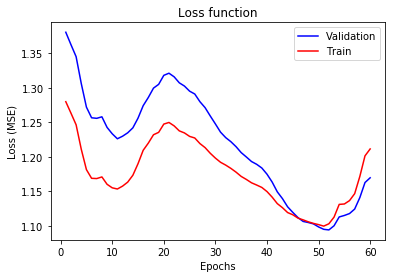

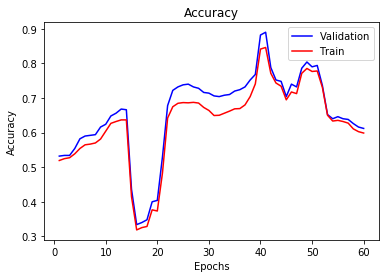

In [15]:
# Training history
plt.figure()
xs = np.arange(1, len(hist['val_loss']) + 1)
plt.plot(xs, hist['val_loss'], c='b', label='Validation')
plt.plot(xs, hist['tr_loss'], c='r', label='Train')

plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('plots/QVC {} loss'.format(name))
plt.show()

plt.figure()
xs = np.arange(1, len(hist['val_acc']) + 1)
plt.plot(xs, hist['val_acc'], c='b', label='Validation')
plt.plot(xs, hist['tr_acc'], c='r', label='Train')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('plots/QVC {} acc'.format(name))
plt.show()

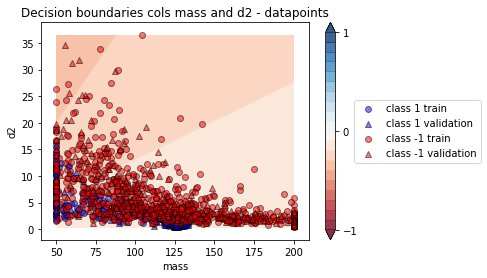

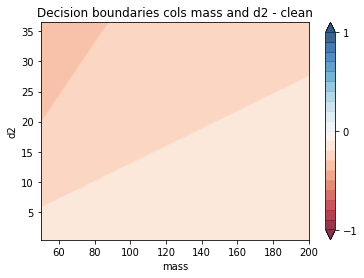

IndexError: index 2 is out of bounds for axis 1 with size 2

In [16]:
# Decision Boundaries
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
for col1 in range(4):
    for col2 in range(col1 + 1, 4):
        min_x = np.min(X[:, col1])
        min_y = np.min(X[:, col2])

        max_x = np.max(X[:, col1])
        max_y = np.max(X[:, col2])

        gran = 20

        xx, yy = np.meshgrid(np.linspace(min_x, max_x, gran), np.linspace(min_y, max_y, gran))
        X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())] 

        # preprocess grid points like data inputs above
        padding = 0.3 * np.ones((len(X_grid), 1))
        X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1)) ]  # pad each input
        normalization = np.sqrt(np.sum(X_grid ** 2, -1))
        X_grid = (X_grid.T / normalization).T  # normalize each input
        features_grid = np.array([get_angles(x) for x in X_grid])  # angles for state preparation are new features
        predictions_grid = [variational_classifier(best_var, angles=f) for f in features_grid]
        Z = np.reshape(predictions_grid, xx.shape)

        # plot decision regions
        cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=.8, extend='both')
        plt.contour(xx, yy, Z, levels=[0.0], colors=('black',), linestyles=('--',), linewidths=(0.8,))
        plt.colorbar(cnt, ticks=[-1, 0, 1])

        # plot data
        plt.scatter(X_train[:,col1][Y_train==1], X_train[:,col2][Y_train==1], c='b', alpha=0.5, marker='o', edgecolors='k', label="class 1 train")
        plt.scatter(X_val[:,col1][Y_val==1], X_val[:,col2][Y_val==1], c='b', alpha=0.5, marker='^', edgecolors='k', label="class 1 validation")
        plt.scatter(X_train[:,col1][Y_train==-1], X_train[:,col2][Y_train==-1], c='r', alpha=0.5, marker='o', edgecolors='k', label="class -1 train")
        plt.scatter(X_val[:,col1][Y_val==-1], X_val[:,col2][Y_val==-1], c='r', alpha=0.5, marker='^', edgecolors='k', label="class -1 validation")

        plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.5), fancybox=True)
        plt.title('Decision boundaries cols {} and {} - datapoints'.format(columns[col1], columns[col2]))
        plt.xlabel(columns[col1])
        plt.ylabel(columns[col2])
        plt.savefig('plots/QVC {} Decision Bounds and Points'.format(name))
        plt.show()

        # preprocess grid points like data inputs above
        padding = 0.3 * np.ones((len(X_grid), 1))
        X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1)) ]  # pad each input
        normalization = np.sqrt(np.sum(X_grid ** 2, -1))
        X_grid = (X_grid.T / normalization).T  # normalize each input
        features_grid = np.array([get_angles(x) for x in X_grid])  # angles for state preparation are new features
        predictions_grid = [variational_classifier(best_var, angles=f) for f in features_grid]
        Z = np.reshape(predictions_grid, xx.shape)

        # plot decision regions
        cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=.8, extend='both')
        plt.contour(xx, yy, Z, levels=[0.0], colors=('black',), linestyles=('--',), linewidths=(0.8,))
        plt.colorbar(cnt, ticks=[-1, 0, 1])
        plt.title('Decision boundaries cols {} and {} - clean'.format(columns[col1], columns[col2]))
        plt.xlabel(columns[col1])
        plt.ylabel(columns[col2])
        plt.savefig('plots/QVC {} Decision Bounds on cols {} and {}'.format(name, columns[col1], columns[col2]))
        plt.show()